In [1]:
import numpy as np 
import pandas as pd 
import keras 
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from keras.models import Sequential  # En modelltyp i Keras som gör det enkelt att skapa lager av neurala nätverk sekventiellt
from keras.layers import Reshape
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import joblib

2025-01-12 19:02:25.413089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
MI = pd.read_csv("PTB/ptbdb_abnormal.csv") 
HC = pd.read_csv("PTB/ptbdb_normal.csv") 

In [3]:
new_column_name = ['label']  #skapar kolumn namn för abnormal data
for num in range(MI.shape[1]-1):
    tem = 'dim' + str(num)
    new_column_name.append(tem)
MI.columns = new_column_name    


column_name = ['label'] #skapar koloumn namn for normal data
for num in range(HC.shape[1]-1):
    tem = 'dim' + str(num)
    column_name.append(tem)
HC.columns = column_name

In [4]:
# Separera data i tränings- och testuppsättningar
train_MI = MI.iloc[0:6500]  # De första 6500 från abnormal för träning
test_MI = MI.iloc[6500:9000]  # De sista 2500 från abnormal för testning
train_HC = HC.iloc[0:2500]  # De första 2500 från normal för träning
test_HC = HC.iloc[2500:3500]  # Rader 2500 till 3500 från normal för testning

# Kombinera abnormal och normal data
train = pd.concat([train_MI, train_HC], sort=True)
test = pd.concat([test_MI, test_HC], sort=True)

# Skapa ytrain och ytest baserat på labels
ytrain = [1 if i < 6500 else 0 for i in range(9000)]  # 1 = abnormal, 0 = normal
ytest = [1 if i < 2500 else 0 for i in range(3500)]   # 1 = abnormal, 0 = normal

# Konvertera etiketter till one-hot encoding
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
#to_categorical: Omvandlar etiketter från numeriska värden till one-hot representation:
# 1 (abnormal) -> [0, 1]
# 0 (normal) -> [1, 0]
# Detta krävs eftersom CNN-modellen använder en softmax-utgång, vilket kräver etiketter i one-hot format.

# Separera signaler från etiketter
Xtrain = train.drop(columns=['label']).values  # Signaldata för träning
Xtest = test.drop(columns=['label']).values  # Signaldata för testning

# Lägg till brus i Xtrain
def add_noise(data, noise_level=0.01):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise


# Skapa brusad data och kombinera
Xtrain_noisy = add_noise(Xtrain)
Xtrain = np.concatenate([Xtrain, Xtrain_noisy], axis=0)  # Kombinera original och brusad data
ytrain = np.concatenate([ytrain, ytrain], axis=0)  # Fördubblar etiketterna för brusad data


# Kontrollera att antal prover matchar
print(f"Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}")
print(f"Xtest shape: {Xtest.shape}, ytest shape: {ytest.shape}")

# Omforma data för Conv1D
Xtrain = Xtrain.reshape(len(Xtrain), 187, 1)  # 187 tidssteg, 1 kanal
Xtest = Xtest.reshape(len(Xtest), 187, 1)

# Normalisera data
scaler = MinMaxScaler(feature_range=(0, 1))
Xtrain = scaler.fit_transform(Xtrain.reshape(-1, 187)).reshape(-1, 187, 1)
Xtest = scaler.transform(Xtest.reshape(-1, 187)).reshape(-1, 187, 1)

joblib.dump(scaler, 'scaler.pkl')


Xtrain shape: (18000, 187), ytrain shape: (18000, 2)
Xtest shape: (3500, 187), ytest shape: (3500, 2)


['scaler.pkl']

In [5]:
train=np.asarray(train)
train=train.reshape(9000, 188, 1) #188 tidsteg (188 dimensioner) , 1 kanal (1-dim EKG))

test=np.asarray(test)
test=test.reshape(3500, 188, 1)
# For conv1d statement: 
#input_shape = (ncols, 1) 

model = Sequential()
model.add(Convolution1D(100, 5, activation='relu', input_shape=(188,1))) #100 filter, filterstorlek= 5 (små , lokala mönster), relu = aktiveringsfunktion
model.add(Convolution1D(100, 10, activation='relu')) #filterstorlek 10, tar in bredare sammanhang
model.add(MaxPooling1D(3))
model.add(Convolution1D(100, 10, activation='relu'))
model.add(Convolution1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5)) #Slumpar bort 50% av anslutningarna för att minska överanpassning.
model.add(Flatten())
model.add(Dense(100, activation='relu')) # Ett dense lager med 100 neuroner och ReLU
model.add(Dense(2, activation='softmax')) #Utgångslager med 2 neuroner för att representera de två klasserna (normal och abnormal)
#print(model_m.summary())
model.compile(optimizer=Adam(learning_rate=0.0005),  # Lägre learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Konvulution lager: extraherar mönster från EKG singal. Mindre filterstorlek -> mindre mönster
# Poolinglager : Reducerar data för att minska beräkningskomplexiteten och generalisera mönstren
#Dense lager: Slutför processen genom att klassificera signalen baserat på de extraherade funktionerna


model.summary()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 184, 100)       │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 175, 100)       │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 58, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 100)        │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 40, 160)        │       160,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 160)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        16,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,262 (1.44 MB)

 Trainable params: 377,262 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) #stoppar innan de blir overfitting

history = model.fit(
    Xtrain, ytrain,  # Använd Xtrain för signaldata
    validation_data=(Xtest, ytest),  # Använd Xtest för valideringssignaler
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 65s 111ms/step - accuracy: 0.8797 - loss: 0.2477 - val_accuracy: 0.9989 - val_loss: 0.0051
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 68s 121ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9986 - val_loss: 0.0065
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 69s 122ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9991 - val_loss: 0.0054


In [7]:
# Save the trained model
joblib.dump(model, 'ECG_model.pkl')
print("Model saved as 'ECG_model.pkl'")

Model saved as 'ECG_model.pkl'


In [8]:
_,accuracy = model.evaluate(test, ytest, verbose=0)
accuracy

0.998285710811615

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9990 - loss: 0.0074
Test Loss: 0.0051000383682549
Test Accuracy: 0.9988571405410767


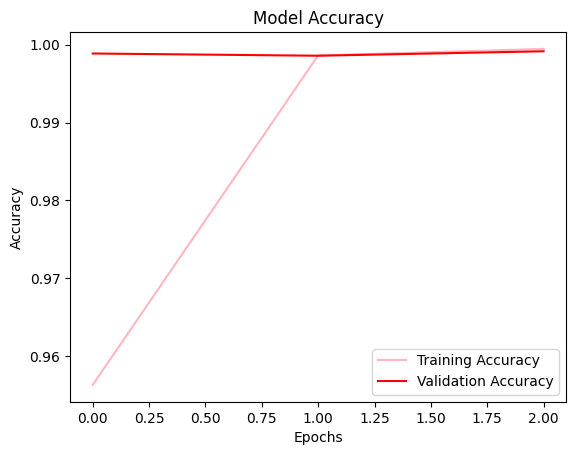

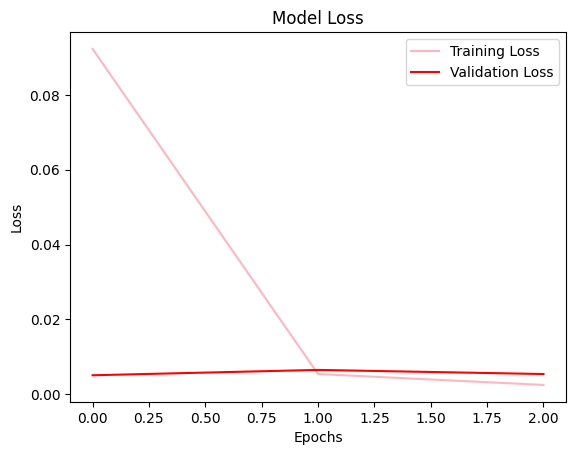

In [9]:
# Utvärdera modellen
test_loss, test_accuracy = model.evaluate(Xtest, ytest)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Visualisera träningshistorik med ljusrosa och röd färg för accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#ffb6c1')  # Ljusrosa för träning
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')  # Röd för validering
plt.legend()
plt.title('Model Accuracy')  # Standardfärg
plt.xlabel('Epochs')         # Standardfärg
plt.ylabel('Accuracy')       # Standardfärg
plt.show()

# Visualisera träningshistorik med ljusrosa och röd färg för loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss', color='#ffb6c1')  # Ljusrosa för träning
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')  # Röd för validering
plt.legend()
plt.title('Model Loss')  # Standardfärg
plt.xlabel('Epochs')     # Standardfärg
plt.ylabel('Loss')       # Standardfärg
plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
    Abnormal       1.00      1.00      1.00      2500

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500



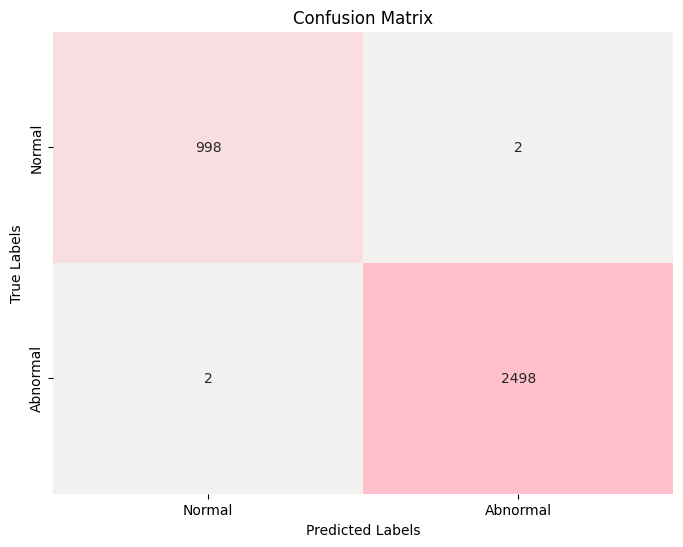

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9990 - loss: 0.0074
Test Loss: 0.0051000383682549
Test Accuracy: 0.9988571405410767


In [10]:
# Gör prediktioner på valideringsdatan
y_pred = model.predict(Xtest) #använder alla atribut i xtest för att predicta en ny y_pred
y_pred_classes = np.argmax(y_pred, axis=1)  # Konvertera prediktioner till klassindex
y_true = np.argmax(ytest, axis=1)  # Konvertera one-hot till klassindex

#Y_pred: predictar utifrån Xtest
#Y_true: Facit på predictade

# Skapar en rapport
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["Normal", "Abnormal"]))

# Skapa en confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Rosa
cmap = sns.light_palette("pink", as_cmap=True)

#Plotta matris
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"], cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Utvärdera modellen på testdatan
test_loss, test_accuracy = model.evaluate(Xtest, ytest)

# Skriv ut resultaten
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


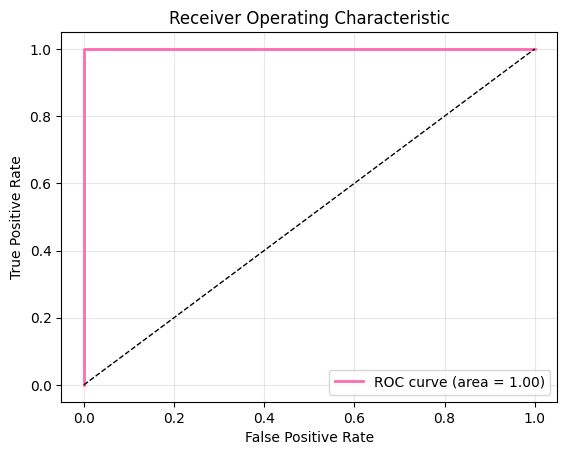

In [11]:
# Generera sannolikheter för klassen 'abnormal'
y_pred_probs = model.predict(Xtest)[:, 1]  # Hämta sannolikheter för klassen 'abnormal'

# Beräkna ROC-kurvan
fpr, tpr, thresholds = roc_curve(ytest.argmax(axis=1), y_pred_probs)

# Beräkna AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plotta ROC-kurvan
plt.figure()
plt.plot(fpr, tpr, color='#ff69b4', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Ljusrosa kurva
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal linje för slumpmässig gissning
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()